<a href="https://colab.research.google.com/github/baroodb/code/blob/main/tf_cats_dogs2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model


IMG_SIZE = [224, 224]
BATCH_SIZE = 32
EPOCHS = 4
AUTOTUNE = tf.data.AUTOTUNE

MODEL_PATH = 'datasets/model'
PLOT_PATH = 'datasets/plot.png'

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [3]:
def load_dataset(url):
  data_dir = tf.keras.utils.get_file(origin=url, 
                                  fname='dataset', 
                                  untar=True, 
                                  cache_dir='.')
  return  data_dir

def clear_path(datapath):
  path = Path(datapath)

  for entry in path.iterdir():
    if entry.is_file():
      file_path = Path(os.path.join(path, entry.name))
      file_path.unlink()

  #content = [entry.name for entry in path.iterdir()]
  return datapath

def make_datasets(datapath):
  normalisation = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)

  train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=datapath, 
                                                                 batch_size=BATCH_SIZE, 
                                                                 image_size=IMG_SIZE, 
                                                                 shuffle=True, 
                                                                 subset='training', 
                                                                 seed=123, 
                                                                 validation_split=0.2)
  
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=datapath, 
                                                                 batch_size=BATCH_SIZE, 
                                                                 image_size=IMG_SIZE, 
                                                                 shuffle=False, 
                                                                 subset='validation', 
                                                                 seed=123, 
                                                                 validation_split=0.2)
  class_names = train_ds.class_names
  
  # Scale 
  train_ds = train_ds.map(lambda image, label: (normalisation(image), label))
  val_ds = val_ds.map(lambda image, label: (normalisation(image), label))

  return train_ds, val_ds, class_names

def build_dataset(url):
  # downlaod the  data
  tarfile_path = load_dataset(url)

  base = '/'.join(tarfile_path.split('/')[:-1])
  data_path = os.path.join(base, 'flower_photos')

  # clear the path 
  data_path = clear_path(data_path)
  
  # make the dataset
  train_ds, val_ds, class_names = make_datasets(data_path)

  # Caching the  dataset 
  train_ds = train_ds.cache().prefetch(AUTOTUNE)
  val_ds = val_ds.cache().prefetch(AUTOTUNE)

  return  (train_ds, val_ds, class_names)


In [4]:
train_ds, val_ds, class_names = build_dataset(url)

228827136/228813984 [==============================] - 3s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


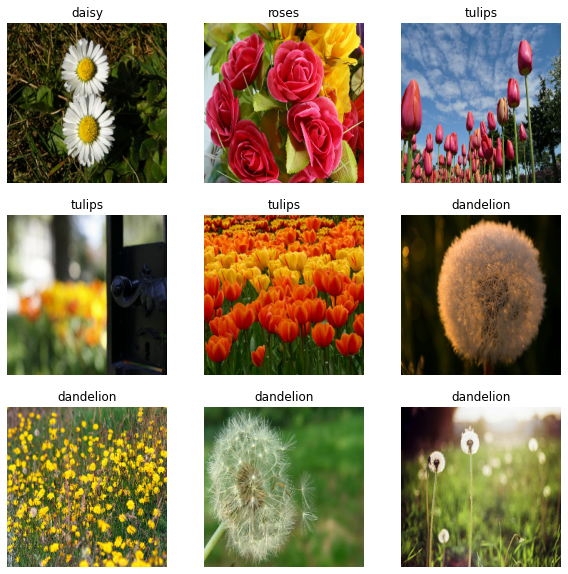

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [6]:
def build_model(input_shape):
  inputs = Input(input_shape)
  x = Conv2D(32, (3, 3), activation='relu')(inputs)
  x = MaxPool2D()(x)
  x = Dropout(0.2)(x)

  x = Conv2D(32, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)
  x = Dropout(0.2)(x)

  x = Flatten()(x)

  x = Dense(64, activation='relu')(x)
  
  outputs = Dense(5)(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

def build_model2(input_shape):
  inputs = Input(input_shape)
  x = Conv2D(64, (3, 3), activation='relu')(inputs)
  x = MaxPool2D()(x)
  
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)

  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  
  outputs = Dense(5)(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model



def plot(H):
  N = np.arange(0, EPOCHS)
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(N, H.history["loss"], label="train_loss")
  plt.plot(N, H.history["val_loss"], label="val_loss")
  plt.plot(N, H.history["accuracy"], label="train_acc")
  plt.plot(N, H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")
  plt.savefig(PLOT_PATH)


In [7]:
def build_and_train(url):
  print("[INFO] Building the dataset ...")
  train_ds, val_ds, class_names = build_dataset(url)

  print("[INFO] Creating the model")
  model = build_model(INPUT_SHAPE)

  print("[INFO] Printing the model summary ...")
  print(model.summary())

  print("[INFO] Compiling the model ...")
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'], 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

  
  print("[INFO] Launching the training job ...")
  H = model.fit(train_ds, 
                   validation_data=val_ds, 
                   epochs=EPOCHS)
  
  print("[INFO] Saving the model ...")
  model.save(MODEL_PATH)

  print("[INFO] Plotting the training ...")
  plot(H)

# 
def build_and_compile_model(input_shape):
  inputs = Input(input_shape)
  x = Conv2D(64, (3, 3), activation='relu')(inputs)
  x = MaxPool2D()(x)
  
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)

  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  
  outputs = Dense(5)(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'], 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

  return model

def build_and_compile_model2(input_shape):
  inputs = Input(input_shape)
  x = Conv2D(32, (3, 3), activation='relu')(inputs)
  x = MaxPool2D()(x)
  
  x = Conv2D(32, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)

  x = Conv2D(32, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)

  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  
  outputs = Dense(5)(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'], 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

  return model  

def build_and_compile_model3(input_shape):
  inputs = Input(input_shape)
  x = Conv2D(16, (3, 3), activation='relu')(inputs)
  x = MaxPool2D()(x)
  
  x = Conv2D(16, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)

  x = Conv2D(16, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)

  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  
  outputs = Dense(5)(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'], 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

  return model

def build_and_compile_model4(input_shape):
  inputs = Input(input_shape)
  x = Conv2D(128, (3, 3), activation='relu')(inputs)
  x = MaxPool2D()(x)
  x = Dropout(0.2)(x)

  x = Conv2D(128, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)
  x = Dropout(0.2)(x)

  x = Conv2D(128, (3, 3), activation='relu')(x)
  x = MaxPool2D()(x)
  x = Dropout(0.2)(x)
  
  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  
  outputs = Dense(5)(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'], 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

  return model

In [8]:
INPUT_SHAPE = [224, 224, 3]

#build_and_train(url)

In [9]:
# Load the dataset
train_ds, val_ds, class_names = build_dataset(url)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


[INFO] Launching the training job ...
Epoch 1/4
92/92 [==============================] - 45s 157ms/step - loss: 1.3621 - accuracy: 0.4087 - val_loss: 1.1520 - val_accuracy: 0.5668
Epoch 2/4
92/92 [==============================] - 11s 121ms/step - loss: 1.0850 - accuracy: 0.5668 - val_loss: 1.4372 - val_accuracy: 0.3747
Epoch 3/4
92/92 [==============================] - 11s 122ms/step - loss: 0.9133 - accuracy: 0.6505 - val_loss: 1.2904 - val_accuracy: 0.4441
Epoch 4/4
92/92 [==============================] - 11s 121ms/step - loss: 0.7221 - accuracy: 0.7306 - val_loss: 1.1687 - val_accuracy: 0.5395
[INFO] Saving the model ...
INFO:tensorflow:Assets written to: datasets/model/assets
[INFO] Plotting the training ...


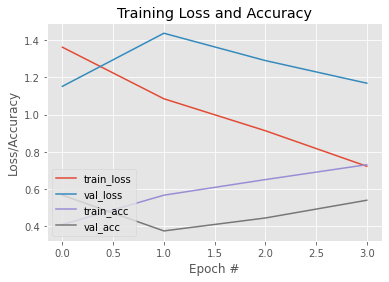

In [10]:
model = build_and_compile_model(INPUT_SHAPE)
print("[INFO] Launching the training job ...")
H = model.fit(train_ds, 
                  validation_data=val_ds, 
                  epochs=EPOCHS)

print("[INFO] Saving the model ...")
model.save(MODEL_PATH)

print("[INFO] Plotting the training ...")
plot(H)

[INFO] Launching the training job ...
Epoch 1/4
92/92 [==============================] - 8s 75ms/step - loss: 1.4031 - accuracy: 0.3941 - val_loss: 1.0243 - val_accuracy: 0.6512
Epoch 2/4
92/92 [==============================] - 6s 67ms/step - loss: 1.1258 - accuracy: 0.5436 - val_loss: 1.0485 - val_accuracy: 0.5368
Epoch 3/4
92/92 [==============================] - 6s 66ms/step - loss: 0.9955 - accuracy: 0.6124 - val_loss: 1.0203 - val_accuracy: 0.5559
Epoch 4/4
92/92 [==============================] - 6s 66ms/step - loss: 0.8712 - accuracy: 0.6703 - val_loss: 0.8971 - val_accuracy: 0.6104
[INFO] Saving the model ...
INFO:tensorflow:Assets written to: datasets/model/assets
[INFO] Plotting the training ...


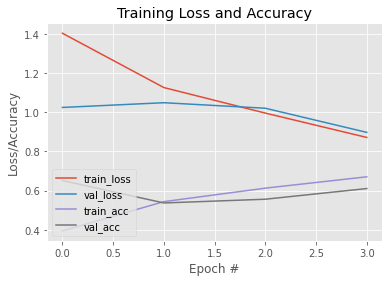

In [11]:

model = build_and_compile_model2(INPUT_SHAPE)
print("[INFO] Launching the training job ...")
H = model.fit(train_ds, 
                  validation_data=val_ds, 
                  epochs=EPOCHS)

print("[INFO] Saving the model ...")
model.save(MODEL_PATH)

print("[INFO] Plotting the training ...")
plot(H)

[INFO] Launching the training job ...
Epoch 1/4
92/92 [==============================] - 5s 49ms/step - loss: 1.4664 - accuracy: 0.3454 - val_loss: 1.0571 - val_accuracy: 0.6063
Epoch 2/4
92/92 [==============================] - 4s 43ms/step - loss: 1.1031 - accuracy: 0.5712 - val_loss: 1.1920 - val_accuracy: 0.4755
Epoch 3/4
92/92 [==============================] - 4s 45ms/step - loss: 0.9262 - accuracy: 0.6526 - val_loss: 1.0228 - val_accuracy: 0.5654
Epoch 4/4
92/92 [==============================] - 4s 43ms/step - loss: 0.7882 - accuracy: 0.7153 - val_loss: 0.8213 - val_accuracy: 0.6921
[INFO] Saving the model ...
INFO:tensorflow:Assets written to: datasets/model/assets
[INFO] Plotting the training ...


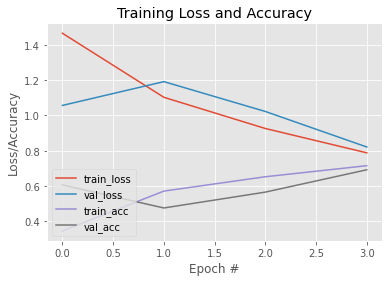

In [12]:
model = build_and_compile_model3(INPUT_SHAPE)
print("[INFO] Launching the training job ...")
H = model.fit(train_ds, 
                  validation_data=val_ds, 
                  epochs=EPOCHS)

print("[INFO] Saving the model ...")
model.save(MODEL_PATH)

print("[INFO] Plotting the training ...")
plot(H)

[INFO] Launching the training job ...
Epoch 1/10
92/92 [==============================] - 38s 362ms/step - loss: 1.6246 - accuracy: 0.2963 - val_loss: 1.4454 - val_accuracy: 0.1649
Epoch 2/10
92/92 [==============================] - 28s 306ms/step - loss: 1.2942 - accuracy: 0.4550 - val_loss: 1.0367 - val_accuracy: 0.5627
Epoch 3/10
92/92 [==============================] - 28s 305ms/step - loss: 1.2097 - accuracy: 0.5133 - val_loss: 1.1237 - val_accuracy: 0.4973
Epoch 4/10
92/92 [==============================] - 28s 305ms/step - loss: 1.1511 - accuracy: 0.5399 - val_loss: 0.9848 - val_accuracy: 0.5722
Epoch 5/10
92/92 [==============================] - 28s 306ms/step - loss: 1.0571 - accuracy: 0.5800 - val_loss: 0.8241 - val_accuracy: 0.7044
Epoch 6/10
92/92 [==============================] - 28s 305ms/step - loss: 0.9373 - accuracy: 0.6345 - val_loss: 0.9121 - val_accuracy: 0.6553
Epoch 7/10
92/92 [==============================] - 28s 304ms/step - loss: 0.7945 - accuracy: 0.6986 - v

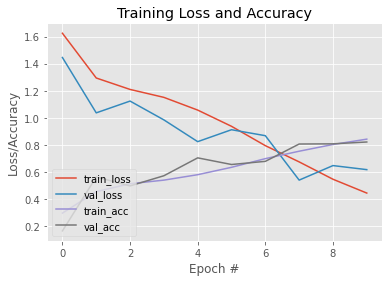

In [13]:
EPOCHS = 10
model = build_and_compile_model4(INPUT_SHAPE)
print("[INFO] Launching the training job ...")
H = model.fit(train_ds, 
                  validation_data=val_ds, 
                  epochs=EPOCHS)

print("[INFO] Saving the model ...")
model.save(MODEL_PATH)

print("[INFO] Plotting the training ...")
plot(H)

In [23]:
data_dir = Path("datasets/flower_photos")
filenames = tf.data.Dataset.list_files(str(data_dir/'*/*'))
len(filenames)

3670